In [ ]:
!pip install ultralytics

#### - Library Import


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import ast
import shutil
import glob
import os

import cv2
# import matplotlib.image as mpimg

#### - Custom Function

In [28]:
# 두 box 영역을 하나의 영역으로 반환하는 function

def merge_boxes(row):
    # None 또는 NaN 값 처리
    yolo_box = row["yolo_box"]
    unet_box = row["unet_box"]

    # 문자열 → 리스트 변환
    if isinstance(yolo_box, str):
        yolo_box = ast.literal_eval(yolo_box)
    if isinstance(unet_box, str):
        unet_box = ast.literal_eval(unet_box)

    # 만약 yolo_box 또는 unet_box가 None이면 0으로 설정
    if yolo_box is None or (isinstance(yolo_box, float) and np.isnan(yolo_box)):
        yolo_box = 0
    if unet_box is None or (isinstance(unet_box, float) and np.isnan(unet_box)):
        unet_box = 0

    # 두 박스가 모두 존재하는 경우 → 최소 좌표 & 최대 좌표 병합
    if (yolo_box != 0) and (unet_box != 0):
        x_min = min(yolo_box[0], unet_box[0])
        y_min = min(yolo_box[1], unet_box[1])
        x_max = max(yolo_box[2], unet_box[2])
        y_max = max(yolo_box[3], unet_box[3])
        return [x_min, y_min, x_max, y_max]

    # 한쪽 박스가 없으면 존재하는 박스 반환
    elif yolo_box == 0:
        return unet_box
    elif unet_box == 0:
        return yolo_box

    # 둘 다 없으면 0 반환
    return 0

In [4]:
# train, validataion 데이터프레임으로 부터 label txt 생성해주는 function

def save_yolo_label(df, label_path, img_width=256, img_height=256, class_id=0):

    # 폴더가 존재하지 않으면 생성
    # os.makedirs(label_path, exist_ok=True)

    for index, row in df.iterrows():
        filename = row["img_filename"]
        merge_box = row["merge_box"]

        if isinstance(merge_box, str):
            merge_box = ast.literal_eval(merge_box)

        x_min, y_min, x_max, y_max = merge_box

        x_center = (x_min + x_max) / 2 / img_width
        y_center = (y_min + y_max) / 2 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        # YOLO 라벨 텍스트 생성
        label_text = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

        label_file = os.path.join(label_path, filename + ".txt")

        # 라벨 파일 저장
        with open(label_file, "w") as f:
            f.write(label_text + "\n")

        if index % 100 == 0:
            print(label_text)

#### - Data Preprocessing

In [2]:
images_train_path = "/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/images/train/"
images_val_path = "/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/images/val/"

labels_train_path = "/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/labels/train/"
labels_val_path = "/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/labels/val/"

data_train_path = "/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/train/"

In [29]:
master_df = pd.read_csv("/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/master_train.csv", index_col=0)
master_df["merge_box"] = master_df.apply(merge_boxes, axis=1)

In [30]:
master_df.head(20)

,img_path,upscale_img_path,label,img_filename,yolo_box,yolo_conf,unet_box,unet_conf,merge_box
0,./train/TRAIN_00000.jpg,./upscale_train/TRAIN_00000.png,Ruddy Shelduck,TRAIN_00000,0,0.000000,"[3, 64, 188, 179]",0.985534,"[3, 64, 188, 179]"
1,./train/TRAIN_00001.jpg,./upscale_train/TRAIN_00001.png,Gray Wagtail,TRAIN_00001,0,0.000000,"[93, 79, 147, 234]",0.951921,"[93, 79, 147, 234]"
2,./train/TRAIN_00002.jpg,./upscale_train/TRAIN_00002.png,Indian Peacock,TRAIN_00002,0,0.000000,"[81, 53, 227, 239]",0.895013,"[81, 53, 227, 239]"
3,./train/TRAIN_00003.jpg,./upscale_train/TRAIN_00003.png,Common Kingfisher,TRAIN_00003,"[2, 93, 92, 236]",0.255118,"[0, 61, 126, 244]",0.980908,"[0, 61, 126, 244]"
4,./train/TRAIN_00004.jpg,./upscale_train/TRAIN_00004.png,Common Kingfisher,TRAIN_00004,"[0, 57, 106, 175]",0.487455,"[0, 37, 152, 190]",0.963232,"[0, 37, 152, 190]"
5,./train/TRAIN_00005.jpg,./upscale_train/TRAIN_00005.png,Common Rosefinch,TRAIN_00005,0,0.000000,"[0, 61, 230, 234]",0.995040,"[0, 61, 230, 234]"
6,./train/TRAIN_00006.jpg,./upscale_train/TRAIN_00006.png,Jungle Babbler,TRAIN_00006,"[62, 66, 225, 191]",0.655208,"[47, 76, 256, 240]",0.944185,"[47, 66, 256, 240]"
7,./train/TRAIN_00007.jpg,./upscale_train/TRAIN_00007.png,Common Tailorbird,TRAIN_00007,"[24, 119, 184, 229]",0.531351,"[20, 119, 256, 241]",0.953129,"[20, 119, 256, 241]"
8,./train/TRAIN_00008.jpg,./upscale_train/TRAIN_00008.png,Indian Peacock,TRAIN_00008,"[77, 58, 221, 185]",0.273331,"[78, 58, 253, 210]",0.988384,"[77, 58, 253, 210]"
9,./train/TRAIN_00009.jpg,./upscale_train/TRAIN_00009.png,Indian Peacock,TRAIN_00009,"[89, 215, 108, 236]",0.721834,0,0.000000,"[89, 215, 108, 236]"


In [31]:
master_df[master_df["img_filename"] == "TRAIN_04810"]

,img_path,upscale_img_path,label,img_filename,yolo_box,yolo_conf,unet_box,unet_conf,merge_box
4810,./train/TRAIN_04810.jpg,./upscale_train/TRAIN_04810.png,Asian Green Bee-Eater,TRAIN_04810,"[184, 223, 186, 226]",0.340621,0,0.0,"[184, 223, 186, 226]"


In [7]:
master_df.to_csv("/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/master_df.csv")

In [8]:
# merge box == 0 인 data idx 찾기

delete_files = master_df[master_df["merge_box"] == 0]["img_filename"].tolist()
print(len(delete_files))

941


In [9]:
# merge box 가 존재하는 data 만 남기기

master_df = master_df[master_df["merge_box"] != 0]
print(len(master_df))

14893


In [10]:
# train, validataion split ~ 0.9 : 0.1

train_df = master_df.sample(frac=0.9, random_state=55)
valid_df = master_df.drop(train_df.index)

train_df.reset_index(inplace=True, drop=True)
valid_df.reset_index(inplace=True, drop=True)

In [11]:
# train data 파인튜닝 폴더로 이동

for idx, row in train_df.iterrows():
    filename = row["img_filename"]
    source = data_train_path + filename + ".jpg"
    shutil.move(source, images_train_path)

In [12]:
# validation data 파인튜닝 폴더로 이동

for idx, row in valid_df.iterrows():
    filename = row["img_filename"]
    source = data_train_path + filename + ".jpg"
    shutil.move(source, images_val_path)

In [ ]:
# label txt 파일 생성

save_yolo_label(train_df, labels_train_path, img_width=256, img_height=256, class_id=0)
save_yolo_label(valid_df, labels_val_path, img_width=256, img_height=256, class_id=0)

In [14]:
yaml_content = """
train: /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/images/train/
val: /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/images/val/
nc: 1
names: ["bird"]
"""

# YAML 파일 생성 및 저장
yaml_path = "/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/yolov8_config.yaml"

with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"✅ YAML 파일 생성 완료: {yaml_path}")

✅ YAML 파일 생성 완료: /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/yolov8_config.yaml


In [15]:
# YOLOv8 Nano (yolov8n.pt)	1,000~5,000	소형 모델, 소량의 데이터로도 학습 가능
# YOLOv8 Small (yolov8s.pt)	5,000~10,000	중간 크기 모델, 적절한 데이터 필요
# YOLOv8 Medium (yolov8m.pt)	10,000~50,000	큰 데이터셋 필요
# YOLOv8 Large (yolov8l.pt)	50,000~100,000	데이터셋이 커야 일반화 가능
# YOLOv8 X-Large (yolov8x.pt)	100,000+	대형 데이터셋 필수

In [16]:
from ultralytics import YOLO

# YOLOv8 모델 로드 (Pretrained)
model = YOLO("yolov8m.pt")  # medium YOLO 모델

# 모델 파인튜닝 (Fine-Tuning)
model.train(data=yaml_path, epochs=50, batch=16, imgsz=64)

100%|██████████| 49.7M/49.7M [00:01<00:00, 44.7MB/s]


Ultralytics 8.3.74 🚀 Python-3.10.6 torch-2.0.1 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/yolov8_config.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

train: Scanning /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/labels/train... 13404 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13404/13404 [00:02<00:00, 5600.17it/s]


train: New cache created: /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/labels/train.cache


val: Scanning /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/labels/val... 1489 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1489/1489 [00:00<00:00, 4385.55it/s]

val: New cache created: /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
No such keys(s): 'mode.use_inf_as_null'
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.705      1.232      1.311         29         64: 100%|██████████| 838/838 [11:36<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.12it/s]

                   all       1489       1489      0.844      0.785       0.85      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.561      0.943      1.215         31         64: 100%|██████████| 838/838 [10:55<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:44<00:00,  1.05it/s]

                   all       1489       1489      0.784      0.658      0.742      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.686      1.064      1.242         24         64: 100%|██████████| 838/838 [12:11<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:44<00:00,  1.05it/s]

                   all       1489       1489      0.679      0.651      0.689      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.727      1.089      1.252         31         64: 100%|██████████| 838/838 [11:09<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:43<00:00,  1.09it/s]

                   all       1489       1489      0.757      0.612       0.71      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.664      1.047      1.225         30         64: 100%|██████████| 838/838 [10:43<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]

                   all       1489       1489      0.813      0.725      0.799      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.602      1.009      1.209         32         64: 100%|██████████| 838/838 [10:49<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:43<00:00,  1.09it/s]

                   all       1489       1489      0.842      0.753      0.833      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.541     0.9659      1.186         29         64: 100%|██████████| 838/838 [10:49<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:44<00:00,  1.06it/s]

                   all       1489       1489      0.837      0.758      0.838      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.502     0.9342      1.171         23         64: 100%|██████████| 838/838 [11:01<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.17it/s]

                   all       1489       1489      0.855      0.753      0.845      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.482     0.9226      1.164         31         64: 100%|██████████| 838/838 [10:06<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]

                   all       1489       1489      0.842      0.778      0.843       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.464      0.908      1.156         24         64: 100%|██████████| 838/838 [10:10<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]

                   all       1489       1489      0.876      0.826      0.879      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.433     0.8919      1.149         26         64: 100%|██████████| 838/838 [10:17<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:42<00:00,  1.12it/s]

                   all       1489       1489      0.857      0.754      0.847      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.422     0.8782       1.15         23         64: 100%|██████████| 838/838 [09:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.882       0.79      0.872       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.401     0.8655      1.143         25         64: 100%|██████████| 838/838 [09:51<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]

                   all       1489       1489      0.896      0.799      0.882      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.384     0.8586      1.134         26         64: 100%|██████████| 838/838 [10:15<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]

                   all       1489       1489      0.894      0.826      0.888      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.383     0.8453      1.133         22         64: 100%|██████████| 838/838 [09:50<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.879      0.801      0.882      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.352     0.8374      1.125         35         64: 100%|██████████| 838/838 [09:56<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.12it/s]

                   all       1489       1489      0.881      0.823      0.891       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.331     0.8226      1.119         29         64: 100%|██████████| 838/838 [09:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]

                   all       1489       1489      0.888       0.79      0.869      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.335     0.8229      1.118         33         64: 100%|██████████| 838/838 [09:49<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.869      0.776      0.841      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.332     0.8174      1.115         33         64: 100%|██████████| 838/838 [10:16<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:42<00:00,  1.10it/s]

                   all       1489       1489      0.898      0.831        0.9      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.314     0.8021      1.109         40         64: 100%|██████████| 838/838 [09:48<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.899      0.847        0.9      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.305     0.8013      1.111         30         64: 100%|██████████| 838/838 [09:45<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.885      0.821      0.893      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.294       0.79      1.108         26         64: 100%|██████████| 838/838 [10:12<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:44<00:00,  1.05it/s]

                   all       1489       1489      0.886      0.826      0.895      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.284     0.7874      1.108         26         64: 100%|██████████| 838/838 [10:21<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:42<00:00,  1.11it/s]

                   all       1489       1489      0.848      0.799      0.866      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.289     0.7782      1.104         28         64: 100%|██████████| 838/838 [10:05<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.833      0.752      0.827      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.276     0.7684      1.102         29         64: 100%|██████████| 838/838 [10:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:42<00:00,  1.11it/s]

                   all       1489       1489      0.896      0.823      0.902      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G       1.26     0.7693      1.094         29         64: 100%|██████████| 838/838 [10:13<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.887       0.84      0.906      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.259     0.7575      1.092         26         64: 100%|██████████| 838/838 [10:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.891       0.84      0.898      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.249     0.7566      1.092         26         64: 100%|██████████| 838/838 [10:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.892      0.828      0.899        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G       1.24     0.7529      1.093         29         64: 100%|██████████| 838/838 [10:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.871      0.829       0.89      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.227     0.7419      1.086         28         64: 100%|██████████| 838/838 [10:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.907      0.846      0.911      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.232     0.7437       1.09         33         64: 100%|██████████| 838/838 [10:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.898      0.846      0.908       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.232     0.7393      1.087         29         64: 100%|██████████| 838/838 [09:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.904      0.846      0.913      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.209       0.73       1.08         25         64: 100%|██████████| 838/838 [09:43<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.906      0.836      0.904      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.202     0.7213      1.079         25         64: 100%|██████████| 838/838 [09:42<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.895      0.823      0.895      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.203     0.7174      1.081         29         64: 100%|██████████| 838/838 [09:42<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.882      0.815      0.878      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.195     0.7183      1.076         21         64: 100%|██████████| 838/838 [09:43<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489       0.88      0.799       0.87      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.186     0.7073      1.073         36         64: 100%|██████████| 838/838 [09:42<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]

                   all       1489       1489      0.903      0.838      0.904      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.181     0.7056      1.074         23         64: 100%|██████████| 838/838 [09:47<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.901      0.846       0.91      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.169      0.699      1.071         29         64: 100%|██████████| 838/838 [09:57<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.892      0.808      0.886      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.168     0.7021      1.069         33         64: 100%|██████████| 838/838 [09:59<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.17it/s]

                   all       1489       1489      0.881      0.831      0.889      0.601


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.044     0.5468      1.069         12         64: 100%|██████████| 838/838 [09:57<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.902      0.856      0.923      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.032     0.5265      1.063         12         64: 100%|██████████| 838/838 [09:58<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.17it/s]

                   all       1489       1489      0.897      0.861      0.921      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.019     0.5206      1.058         12         64: 100%|██████████| 838/838 [09:57<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.913      0.854      0.925      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.018     0.5069      1.055         12         64: 100%|██████████| 838/838 [09:57<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.17it/s]

                   all       1489       1489      0.915      0.859      0.927       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.002     0.5003      1.049         12         64: 100%|██████████| 838/838 [09:46<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]

                   all       1489       1489       0.92      0.851      0.925      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.9907      0.496      1.044         12         64: 100%|██████████| 838/838 [09:45<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489       0.92      0.852      0.925       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.9883     0.4903      1.046         12         64: 100%|██████████| 838/838 [09:42<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]

                   all       1489       1489      0.922       0.86      0.927      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.9815     0.4859      1.043         12         64: 100%|██████████| 838/838 [09:40<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.921      0.862      0.927      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.9737     0.4816      1.041         12         64: 100%|██████████| 838/838 [09:40<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:40<00:00,  1.16it/s]

                   all       1489       1489      0.924      0.863      0.928      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.9701     0.4705      1.039         12         64: 100%|██████████| 838/838 [09:53<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.13it/s]

                   all       1489       1489      0.928      0.862      0.928      0.644



50 epochs completed in 9.031 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.74 🚀 Python-3.10.6 torch-2.0.1 CPU (Apple M2)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:41<00:00,  1.14it/s]


                   all       1489       1489      0.924      0.863      0.928      0.645
Speed: 0.0ms preprocess, 26.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x31d311570>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    

In [2]:
from ultralytics import YOLO

# 모델 불러오기
model = YOLO("/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/finetuning/runs/detect/train/weights/best.pt")  # 학습된 모델 불러오기

In [42]:
# finetuning 된 모델로 새 탐지하는 function
def detect_bird(image_path, model):
    results = model(image_path)
    # result = model(image_path, imgsz=1024) -- input image resizing
    
    highest_confidence = 0
    best_box = None
    is_detected = True

    for result in results:
        for box in result.boxes:
            conf = float(box.conf[0])

            if conf > highest_confidence:  # 'bird' class ID == 14
                highest_confidence = conf
                best_box = [int(x) for x in box.xyxy[0]]

    if best_box:
        return best_box, highest_confidence, is_detected
    else:
        return 0, 0, False

# box 와 image path 를 input 으로 받아 그려주는 function
def draw_image(box, image_path, high_resoloution_path=None, is_train=False):
    if is_train:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    x_min, y_min, x_max, y_max = map(int, box)
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR이므로 RGB로 변환
    cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (63, 0, 0), 1)
        
    row_image = Image.open(image_path)
    axes[0].imshow(row_image)
    axes[0].set_title("Before (Original Image with low resolution)")
    axes[0].axis("off")

    # 원본 이미지 (탐지된 바운딩 박스 포함)
    axes[1].imshow(image_rgb)
    axes[1].set_title("Before (Original Image with Bounding Box)")
    axes[1].axis("off")

    # train 이미지일 경우 고해상도 이미지도 같이 출력
    if is_train and high_resoloution_path:
        high_resolution_image = Image.open(high_resoloution_path)
        axes[2].imshow(row_image)
        axes[2].set_title("Before (Original Image with low resolution)")
        axes[2].axis("off")

    plt.show()

In [48]:
test_path = "/Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/"

test_seq = [
    "TEST_00001.jpg",
    "TEST_00002.jpg",
    "TEST_00003.jpg",
    "TEST_00004.jpg",
    "TEST_00005.jpg",
    "TEST_00006.jpg",
    "TEST_00007.jpg",
    "TEST_00008.jpg",
    "TEST_00009.jpg",
    "TEST_00010.jpg",
    "TEST_00011.jpg",
    "TEST_00012.jpg",
    "TEST_00013.jpg",
    "TEST_00014.jpg",
    "TEST_00015.jpg",
    "TEST_00016.jpg",
    "TEST_00017.jpg",
    "TEST_00018.jpg",
    "TEST_00019.jpg",
    "TEST_00020.jpg"
    ]


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00001.jpg: 64x64 1 bird, 38.8ms
Speed: 0.4ms preprocess, 38.8ms inference, 0.7ms postprocess per image at shape (1, 3, 64, 64)
TEST_00001.jpg  -- 객체 탐지 score :  0.6101570129394531


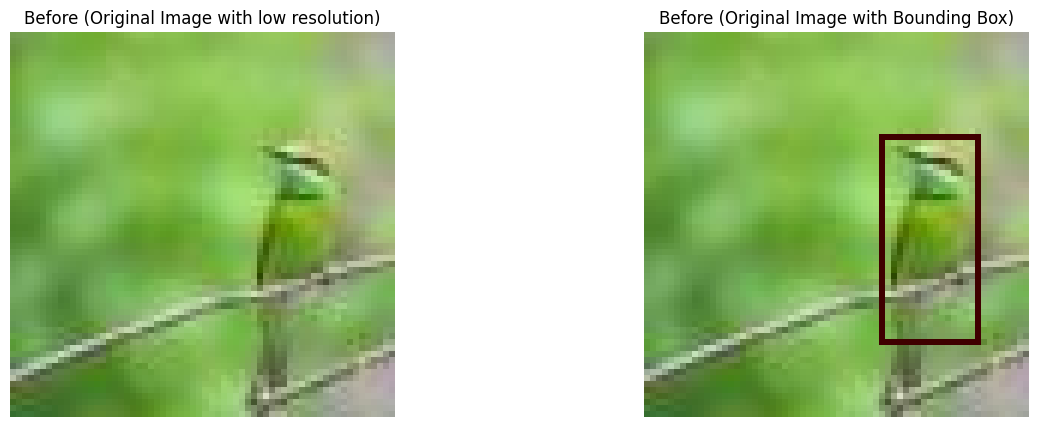


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00002.jpg: 64x64 1 bird, 13.6ms
Speed: 0.2ms preprocess, 13.6ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00002.jpg  -- 객체 탐지 score :  0.3339589238166809


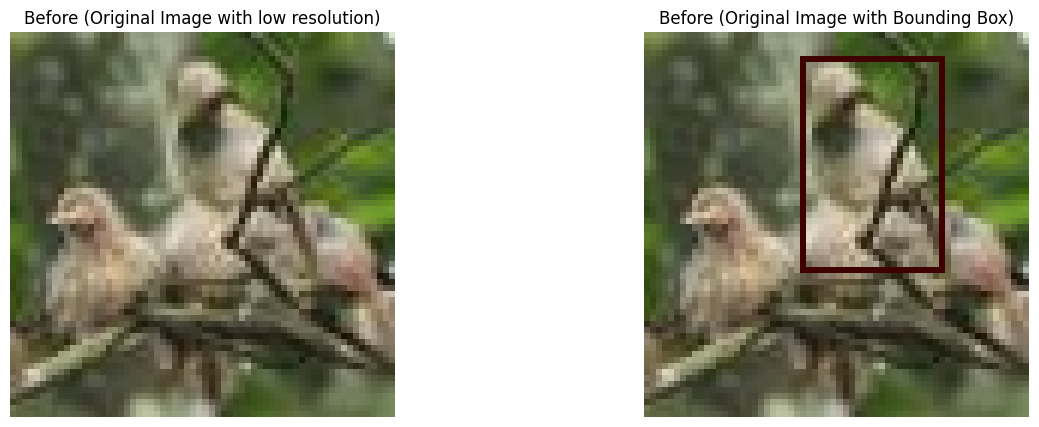


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00003.jpg: 64x64 1 bird, 14.7ms
Speed: 0.3ms preprocess, 14.7ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00003.jpg  -- 객체 탐지 score :  0.6777723431587219


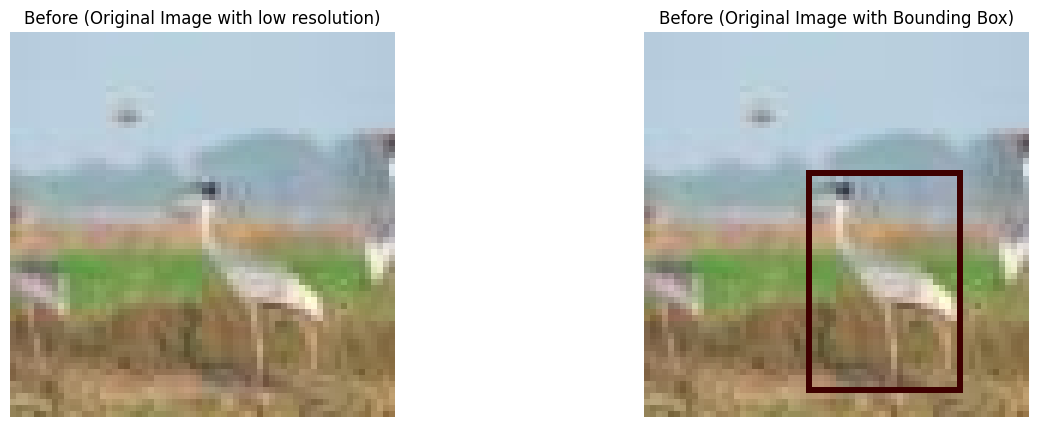


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00004.jpg: 64x64 (no detections), 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 0.2ms postprocess per image at shape (1, 3, 64, 64)

image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00005.jpg: 64x64 1 bird, 12.6ms
Speed: 0.3ms preprocess, 12.6ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00005.jpg  -- 객체 탐지 score :  0.7839784622192383


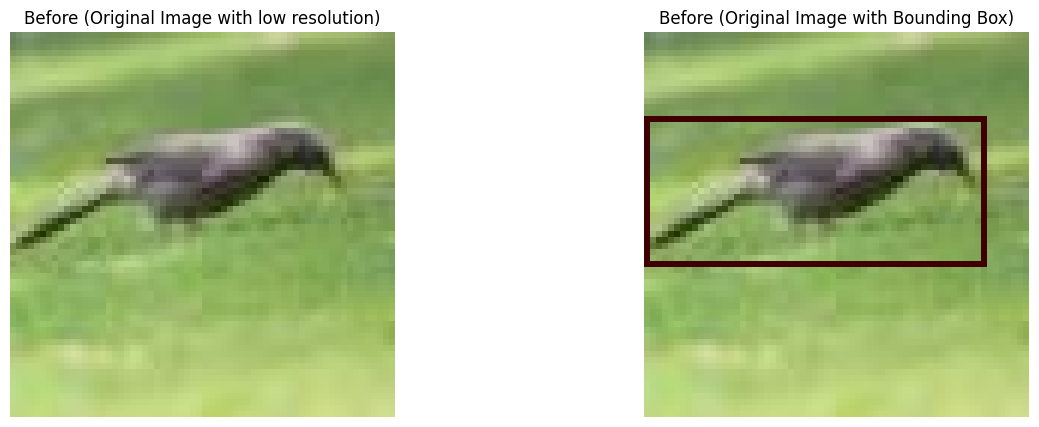


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00006.jpg: 64x64 1 bird, 27.7ms
Speed: 0.4ms preprocess, 27.7ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00006.jpg  -- 객체 탐지 score :  0.5692267417907715


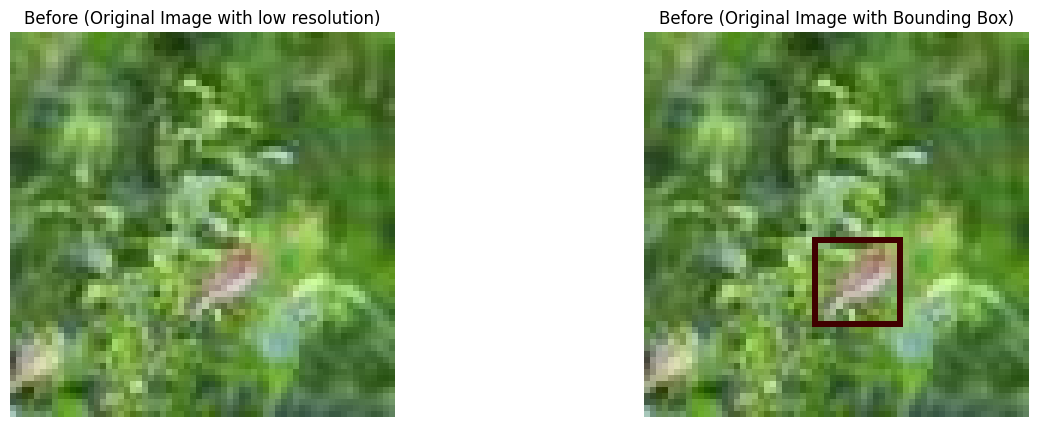


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00007.jpg: 64x64 1 bird, 12.3ms
Speed: 0.1ms preprocess, 12.3ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00007.jpg  -- 객체 탐지 score :  0.7705472111701965


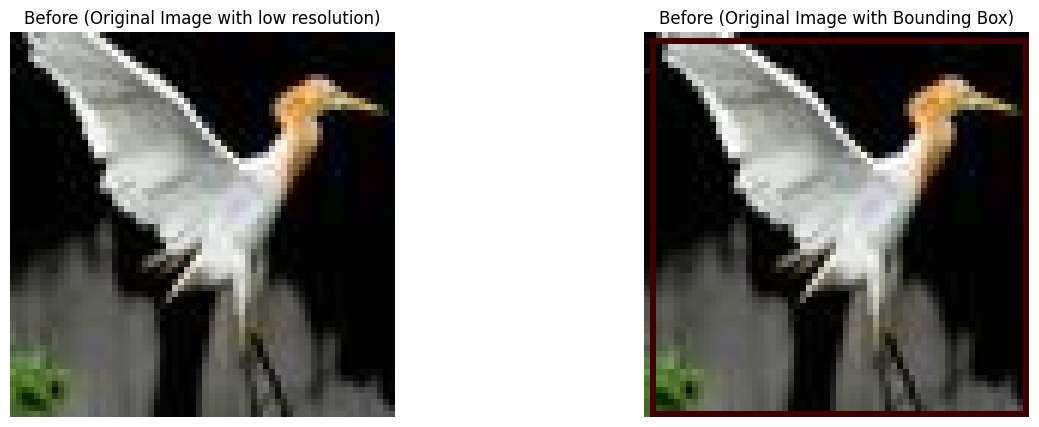


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00008.jpg: 64x64 1 bird, 13.7ms
Speed: 0.2ms preprocess, 13.7ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00008.jpg  -- 객체 탐지 score :  0.77504563331604


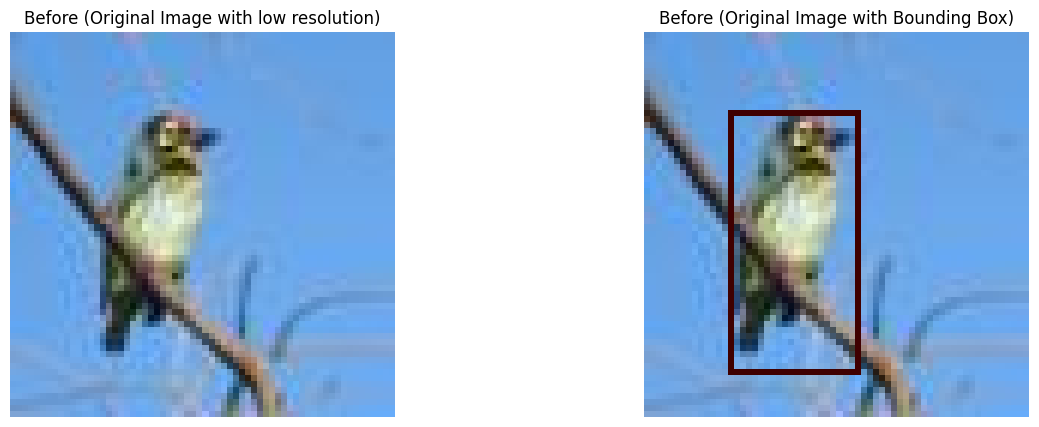


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00009.jpg: 64x64 1 bird, 13.3ms
Speed: 0.2ms preprocess, 13.3ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00009.jpg  -- 객체 탐지 score :  0.8615859746932983


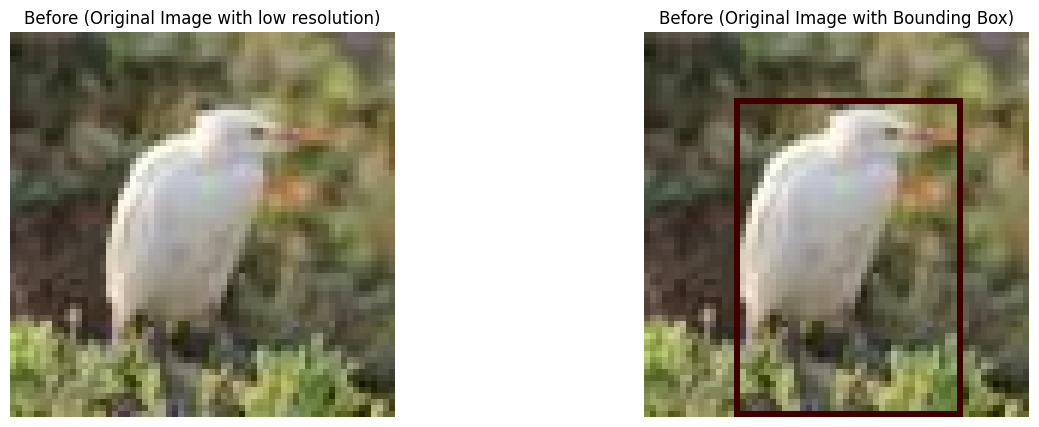


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00010.jpg: 64x64 1 bird, 12.0ms
Speed: 0.1ms preprocess, 12.0ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00010.jpg  -- 객체 탐지 score :  0.8249965906143188


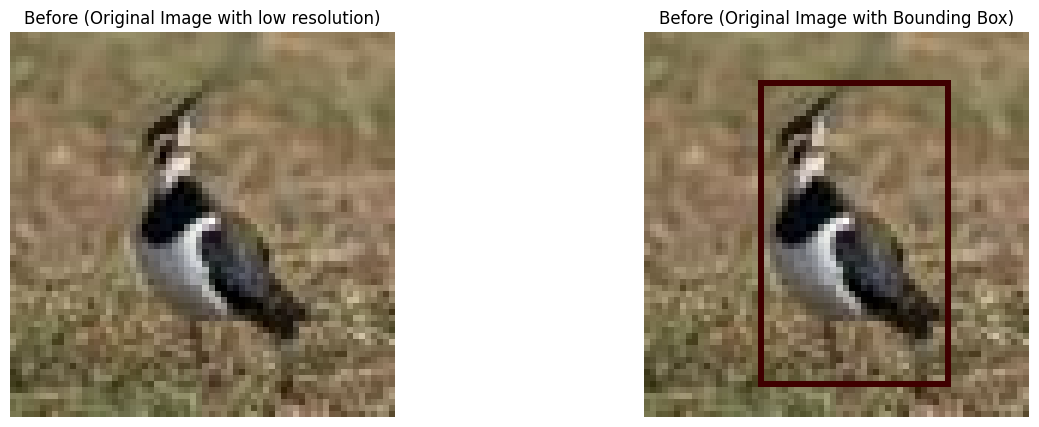


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00011.jpg: 64x64 1 bird, 12.8ms
Speed: 0.1ms preprocess, 12.8ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00011.jpg  -- 객체 탐지 score :  0.32226234674453735


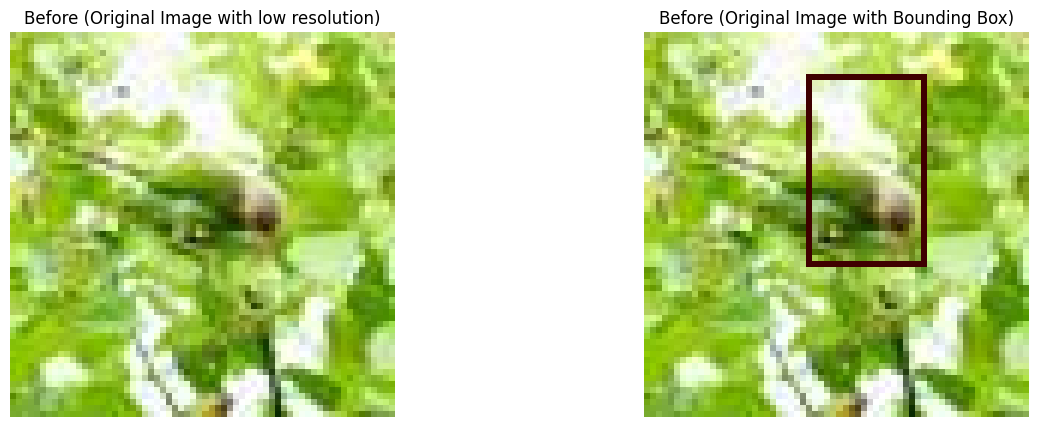


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00012.jpg: 64x64 1 bird, 12.2ms
Speed: 0.1ms preprocess, 12.2ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00012.jpg  -- 객체 탐지 score :  0.8162502646446228


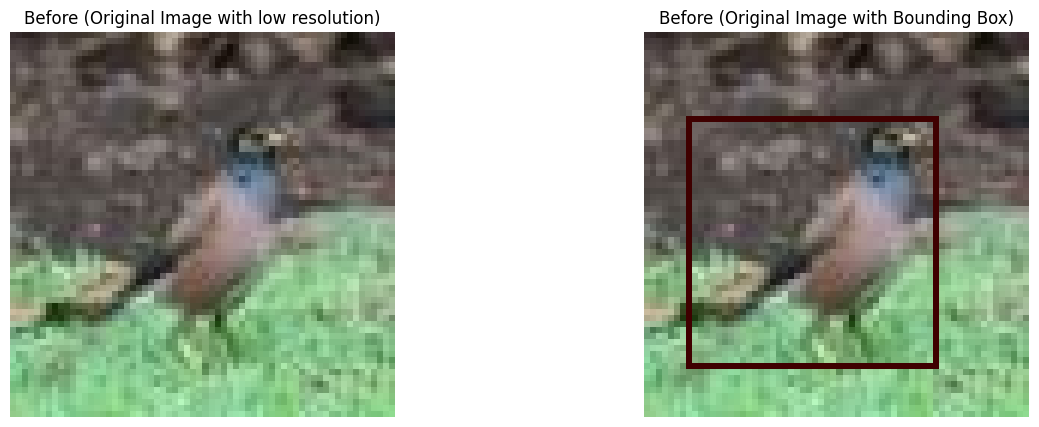


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00013.jpg: 64x64 2 birds, 13.0ms
Speed: 0.1ms preprocess, 13.0ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00013.jpg  -- 객체 탐지 score :  0.64442378282547


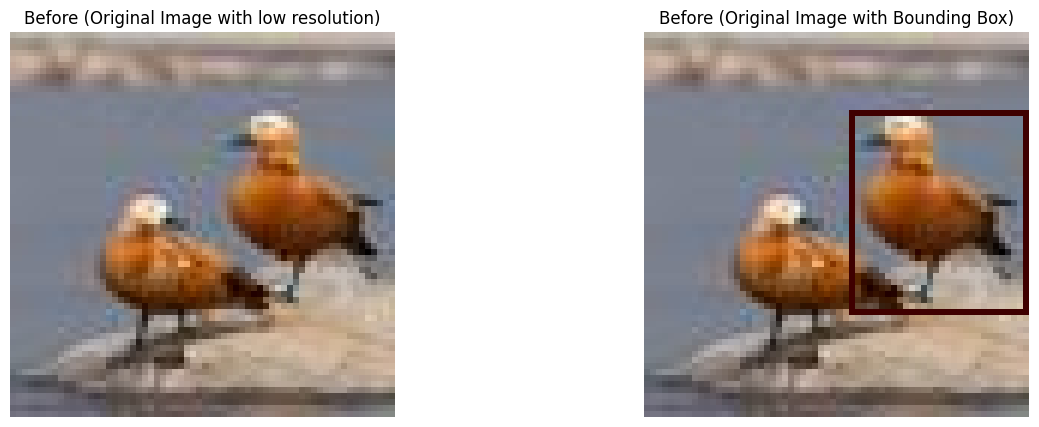


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00014.jpg: 64x64 1 bird, 12.3ms
Speed: 0.1ms preprocess, 12.3ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00014.jpg  -- 객체 탐지 score :  0.8881598711013794


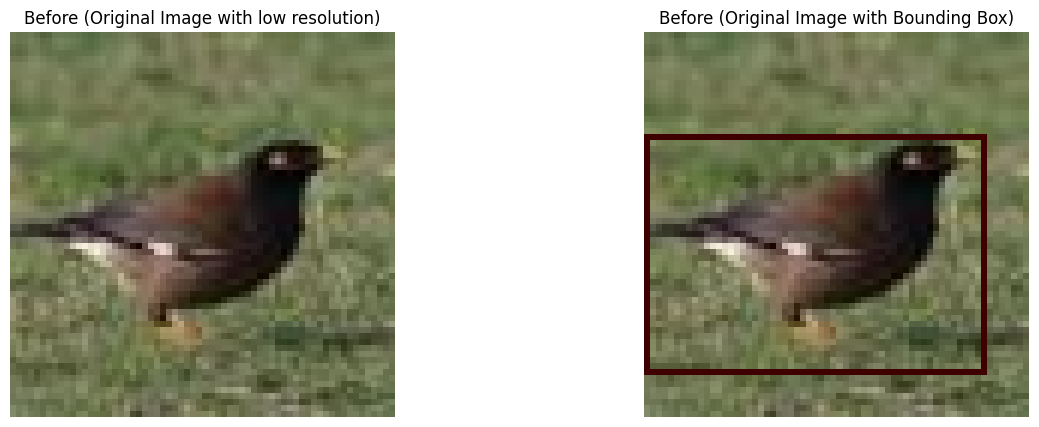


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00015.jpg: 64x64 1 bird, 13.3ms
Speed: 0.1ms preprocess, 13.3ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00015.jpg  -- 객체 탐지 score :  0.5290669202804565


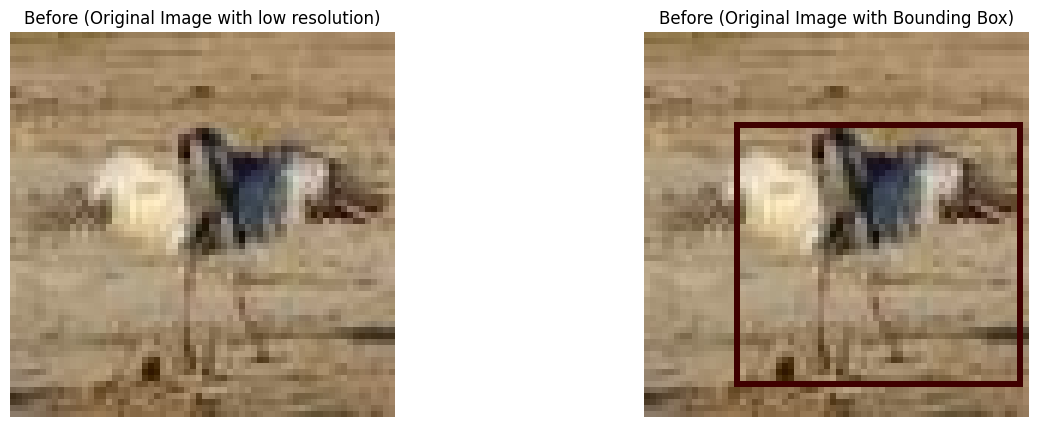


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00016.jpg: 64x64 (no detections), 12.2ms
Speed: 0.1ms preprocess, 12.2ms inference, 0.2ms postprocess per image at shape (1, 3, 64, 64)

image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00017.jpg: 64x64 1 bird, 14.2ms
Speed: 0.2ms preprocess, 14.2ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00017.jpg  -- 객체 탐지 score :  0.7643162608146667


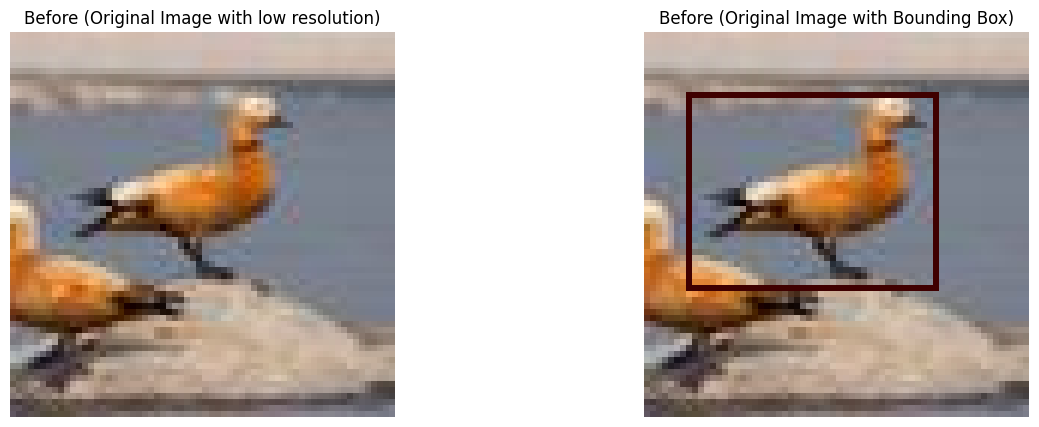


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00018.jpg: 64x64 1 bird, 12.4ms
Speed: 0.1ms preprocess, 12.4ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00018.jpg  -- 객체 탐지 score :  0.8432416319847107


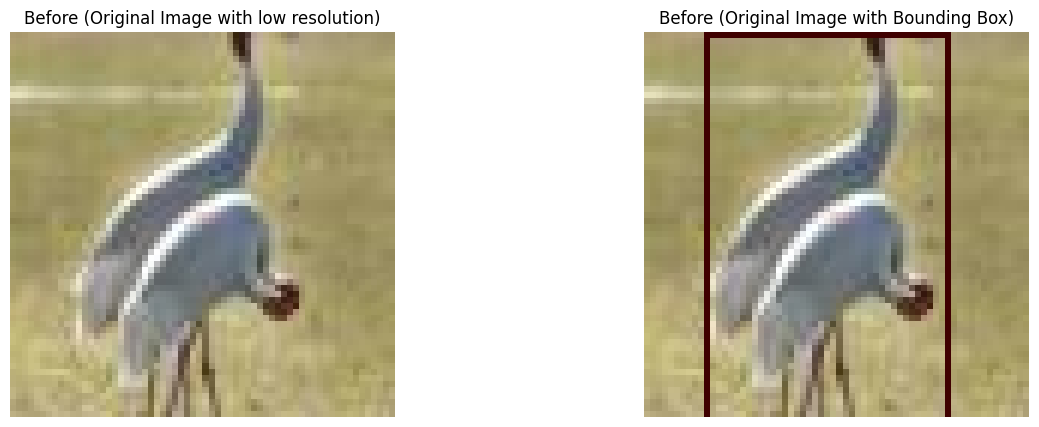


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00019.jpg: 64x64 2 birds, 13.8ms
Speed: 0.1ms preprocess, 13.8ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00019.jpg  -- 객체 탐지 score :  0.5055803060531616


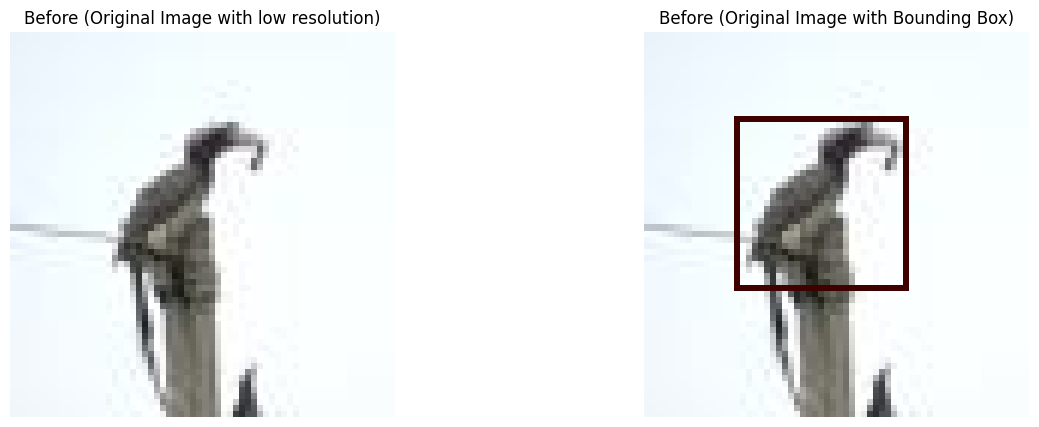


image 1/1 /Users/honey/Desktop/2025-1 KUBIG/25 Winter/DL study/팀프로젝트/data/open/test/TEST_00020.jpg: 64x64 1 bird, 14.2ms
Speed: 0.1ms preprocess, 14.2ms inference, 0.3ms postprocess per image at shape (1, 3, 64, 64)
TEST_00020.jpg  -- 객체 탐지 score :  0.34593871235847473


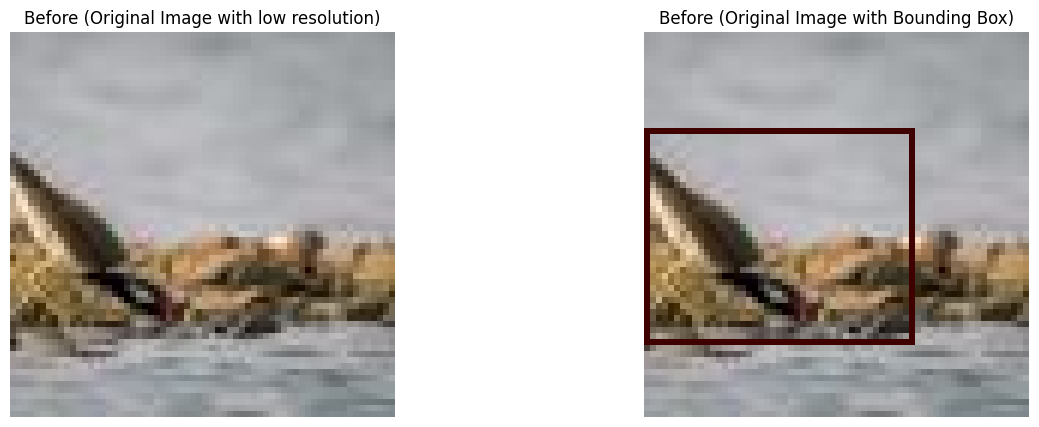

2 개의 image 가 탐지되지 않음


In [49]:
cnt = 0

for test_image in test_seq:
    test = test_path + test_image
    best_box, conf_score, is_detected = detect_bird(test, model)
    if not is_detected:
        cnt += 1
        continue
    print(test_image, " -- 객체 탐지 score : ", conf_score)
    draw_image(best_box, test)

print(cnt, "개의 image 가 탐지되지 않음")